In [8]:
import re
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt
import json

In [33]:
def process_tweet(tweet):
    """ Takes in a string, returns a list words in the string that aren't stopwords
    Parameters:
        tweet (string):  string of text to be tokenized
    Returns:
        stopwords_removed (list): list of all words in tweet, not including stopwords
    """
    stopwords_list=stopwords.words('english') +list(string.punctuation)
    stopwords_list += ["'",'"','...','``','…','’','‘','“',"''",'""','”','”','co',"'s'",'\'s','n\'t','\'m','\'re','amp','https']
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token not in stopwords_list]
    return stopwords_removed

In [4]:
def tokenized(series):
    """ Takes in a series containing strings or lists of strings, and creates a single list of all the words
    Parameters:
        series (series): series of text in the form of strings or lists of string 

    Returns:
        tokens (list): list of every word in the series, not including stopwords
    """

    corpus = ' '.join([tweet.lower() if type(tweet)==str else ' '.join([tag.lower() for tag in tweet]) for tweet in series])
    tokens = process_tweet(corpus)
    return tokens

In [5]:
def wordfrequency(series, top):
    """ Returns the frequency of words in a list of strings.
    Parameters:
        series (iterable): List of strings to be combined and analyzed
        top (int): The number of top words to return.
    Returns:
        list (tuples): List of word and value pairs for the top words in the series.
    """
    frequencies = FreqDist(tokenized(series))
    return frequencies.most_common(top)

In [35]:
def create_wordcloud(series, *top):
    """ Take in a list of lists and create a WordCloud visualization for those terms.
    Parameters:
            series (iterable): A list of lists containing strings.
    Returns:
        None: The ouput is a visualization of the strings in series in terms of the
            frequency of their occurrence.
    """

    vocab = tokenized(series)
    if not top[0]:
        top[0]=200
    cloud=WordCloud(max_words=top[0]).generate(' '.join([word for word in vocab]))
    plt.imshow(cloud,interpolation='bilinear')
    plt.plot(figsize = (48,24))
    plt.axis('off')
    plt.show();

In [15]:
with open('data/tweets.json', 'r') as f:
    data = json.load(f)

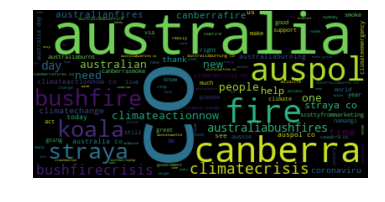

In [36]:
create_wordcloud([tweet['text'] for tweet in data.values()], 200)